In [1]:
%pip install yfinance pandas ta scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## 1. Data Fetching

We download historical daily data for the S&P 500 index (`^GSPC`) from Yahoo Finance. For reproducibility, we use a fixed date range from January 1, 2018, to January 1, 2023, instead of a relative period like "5y", which depends on the current date.

In [3]:
# =============================================================================
# PART 1: Data Fetching and Technical Indicator Calculation
# =============================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, random

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

def fetch_data(ticker="^GSPC", start="2018-01-01", end="2023-01-01"):
    """
    Download historical data for the given ticker.
    """
    data = yf.download(ticker, start=start, end=end)
    # Flatten multi-index columns if present
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

def compute_indicators(data, window=9):
    """
    Compute a full set of technical indicators and add them to the DataFrame.
    """
    close = data['Close']
    high = data['High']
    low = data['Low']
    volume = data['Volume']

    # --- Price Trend Indicators ---
    data['SMA'] = ta.trend.sma_indicator(close, window=window)
    data['EMA'] = ta.trend.ema_indicator(close, window=window)
    data['WMA'] = ta.trend.wma_indicator(close, window=window)
    data['MACD'] = ta.trend.macd_diff(close)
    data['Parabolic_SAR'] = ta.trend.psar_down_indicator(high, low, close)
    data['Ichimoku'] = ta.trend.ichimoku_a(high, low)

    # --- Momentum Indicators ---
    data['RSI'] = ta.momentum.rsi(close, window=window)
    data['Stochastic_Oscillator'] = ta.momentum.stoch(high, low, close)
    data['ROC'] = ta.momentum.roc(close, window=window)
    data['MOM'] = ta.momentum.roc(close, window=window)  # same as ROC
    data['Williams_R'] = ta.momentum.williams_r(high, low, close)

    # --- Volatility Indicators ---
    data['Bollinger_Mavg'] = ta.volatility.bollinger_mavg(close)
    data['ATR'] = ta.volatility.average_true_range(high, low, close)

    # --- Volume Indicators ---
    data['OBV'] = ta.volume.on_balance_volume(close, volume)
    data['Accum_Dist'] = ta.volume.acc_dist_index(high, low, close, volume)
    data['MFI'] = ta.volume.money_flow_index(high, low, close, volume, window=window)
    data['VWAP'] = ta.volume.volume_weighted_average_price(high, low, close, volume, window=window)

    data.dropna(inplace=True)
    return data

# Download data and compute all indicators once
data = fetch_data()
data = compute_indicators(data, window=9)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
c:\Users\zulfa\anaconda3\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


##2: Define the Target Variable
Explanation
The target variable is defined as a binary indicator where a value of 1 means that the next day's closing price is higher than today's closing price, and 0 otherwise. We also remove the last row to ensure proper alignment after shifting.

In [4]:
# =============================================================================
# PART 2: Define the Target Variable
# =============================================================================
# Define next-day price movement: 1 if next day's close > current close, else 0
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data = data.iloc[:-1]  # Remove the last row to align with the shifted target


##3: Feature Importances by Category (Separate Models)
Explanation
To understand the relative importance of features within each category, we train separate AdaBoost models on the following categories:

Price Trend: SMA, EMA, WMA, MACD, Parabolic_SAR, Ichimoku
Momentum: RSI, Stochastic_Oscillator, ROC, MOM, Williams_R
Volatility: Bollinger_Mavg, ATR
Volume: OBV, Accum_Dist, MFI, VWAP
Each model is trained on only the features from one category, and their feature importances are then visualized.

### Calculating Feature Importances per Category (Separate Models)


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ Processed Price Trend
✅ Processed Momentum


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ Processed Volatility


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


✅ Processed Volume


C:\Users\zulfa\AppData\Local\Temp\ipykernel_15020\2187154998.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='coolwarm', ax=axes[idx])
C:\Users\zulfa\AppData\Local\Temp\ipykernel_15020\2187154998.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='coolwarm', ax=axes[idx])
C:\Users\zulfa\AppData\Local\Temp\ipykernel_15020\2187154998.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='co

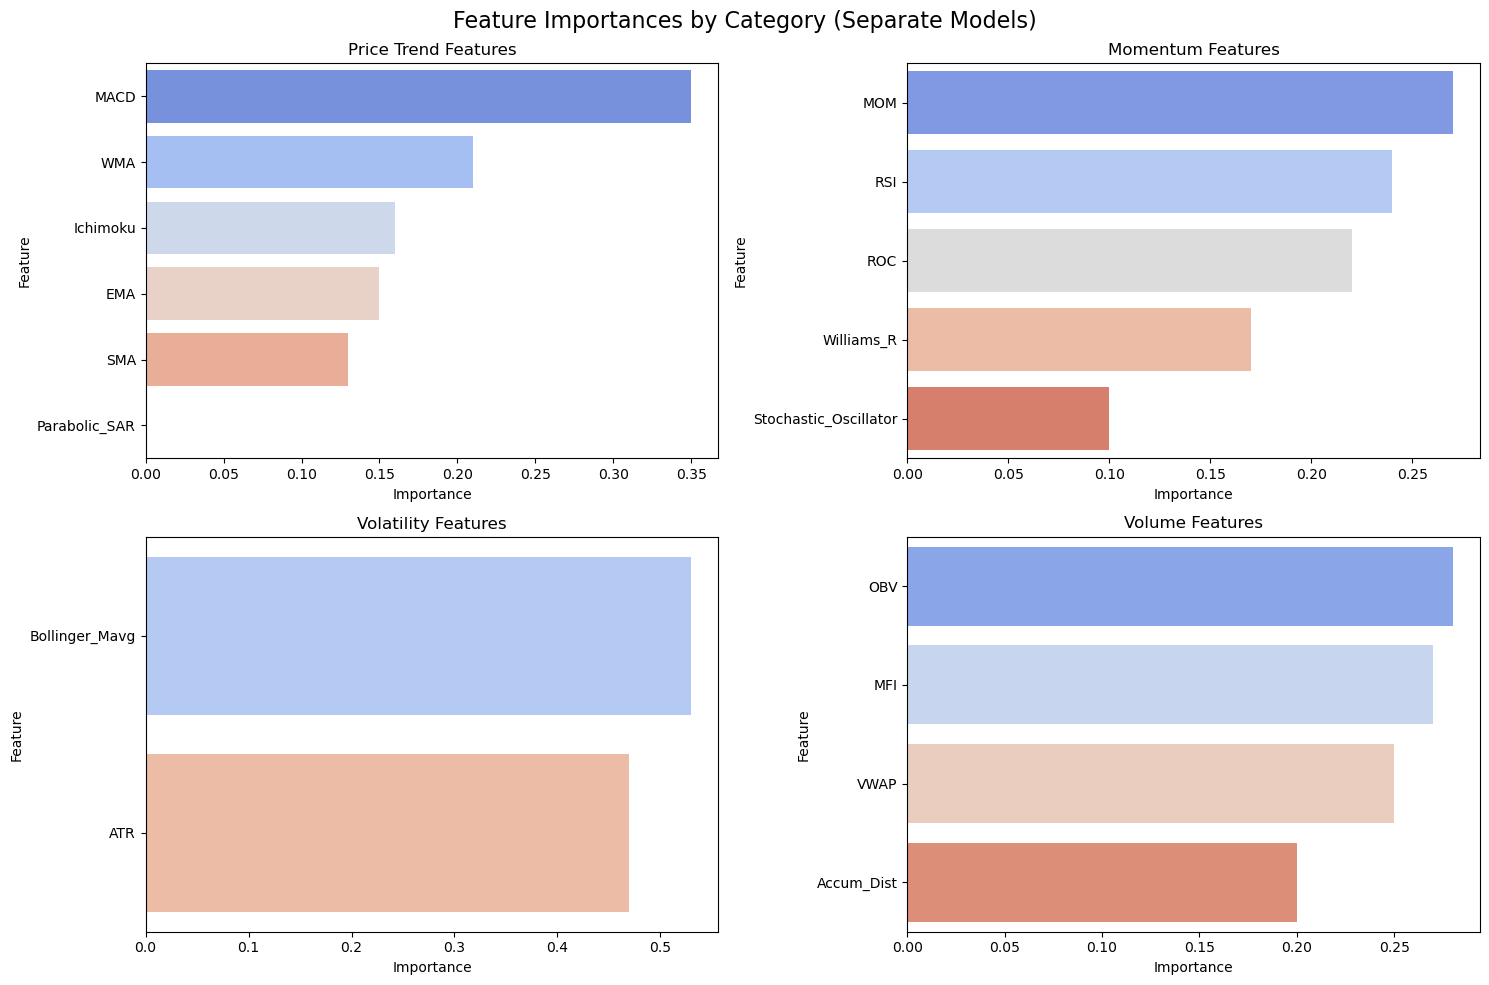

In [5]:
# =============================================================================
# PART 3: Feature Importances by Category (Separate Models)
# =============================================================================
categories = {
    'Price Trend': ['SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku'],
    'Momentum': ['RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_R'],
    'Volatility': ['Bollinger_Mavg', 'ATR'],
    'Volume': ['OBV', 'Accum_Dist', 'MFI', 'VWAP']
}

feature_importances = {}
print("### Calculating Feature Importances per Category (Separate Models)")

for category, feats in categories.items():
    # Prepare data for just this category
    X_cat = data[feats]
    y_cat = data['Target']

    # Scale the features
    scaler = StandardScaler()
    X_cat_scaled = scaler.fit_transform(X_cat)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_cat_scaled, y_cat, test_size=0.2, random_state=42
    )

    # Train an AdaBoost model on just these features
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Store the feature importances
    importances = model.feature_importances_
    feature_importances[category] = dict(zip(feats, importances))
    print(f"✅ Processed {category}")

# Plot separate bar charts for each category
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (category, imp_dict) in enumerate(feature_importances.items()):
    df_imp = pd.DataFrame(list(imp_dict.items()), columns=['Feature', 'Importance'])
    df_imp = df_imp.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=df_imp, palette='coolwarm', ax=axes[idx])
    axes[idx].set_title(f"{category} Features")
    axes[idx].set_xlabel("Importance")
    axes[idx].set_ylabel("Feature")

plt.suptitle("Feature Importances by Category (Separate Models)", fontsize=16)
plt.tight_layout()
plt.show()


##4: Evaluate Combinations of Selected Features (1-8 Indicators)
Explanation
We now focus on a specific subset of eight indicators chosen from our categories. These are:

Price Trend: Ichimoku, EMA
Momentum: RSI, ROC
Volatility: Bollinger_Mavg, ATR
Volume: OBV, Accum_Dist
We generate all possible combinations (from 1 to 8 indicators) using these selected features and evaluate each combination using a default AdaBoost classifier. For each combination size, we record the top 5 combinations based on accuracy.


Selected indicators for combination evaluation: ['MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI']


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\zul

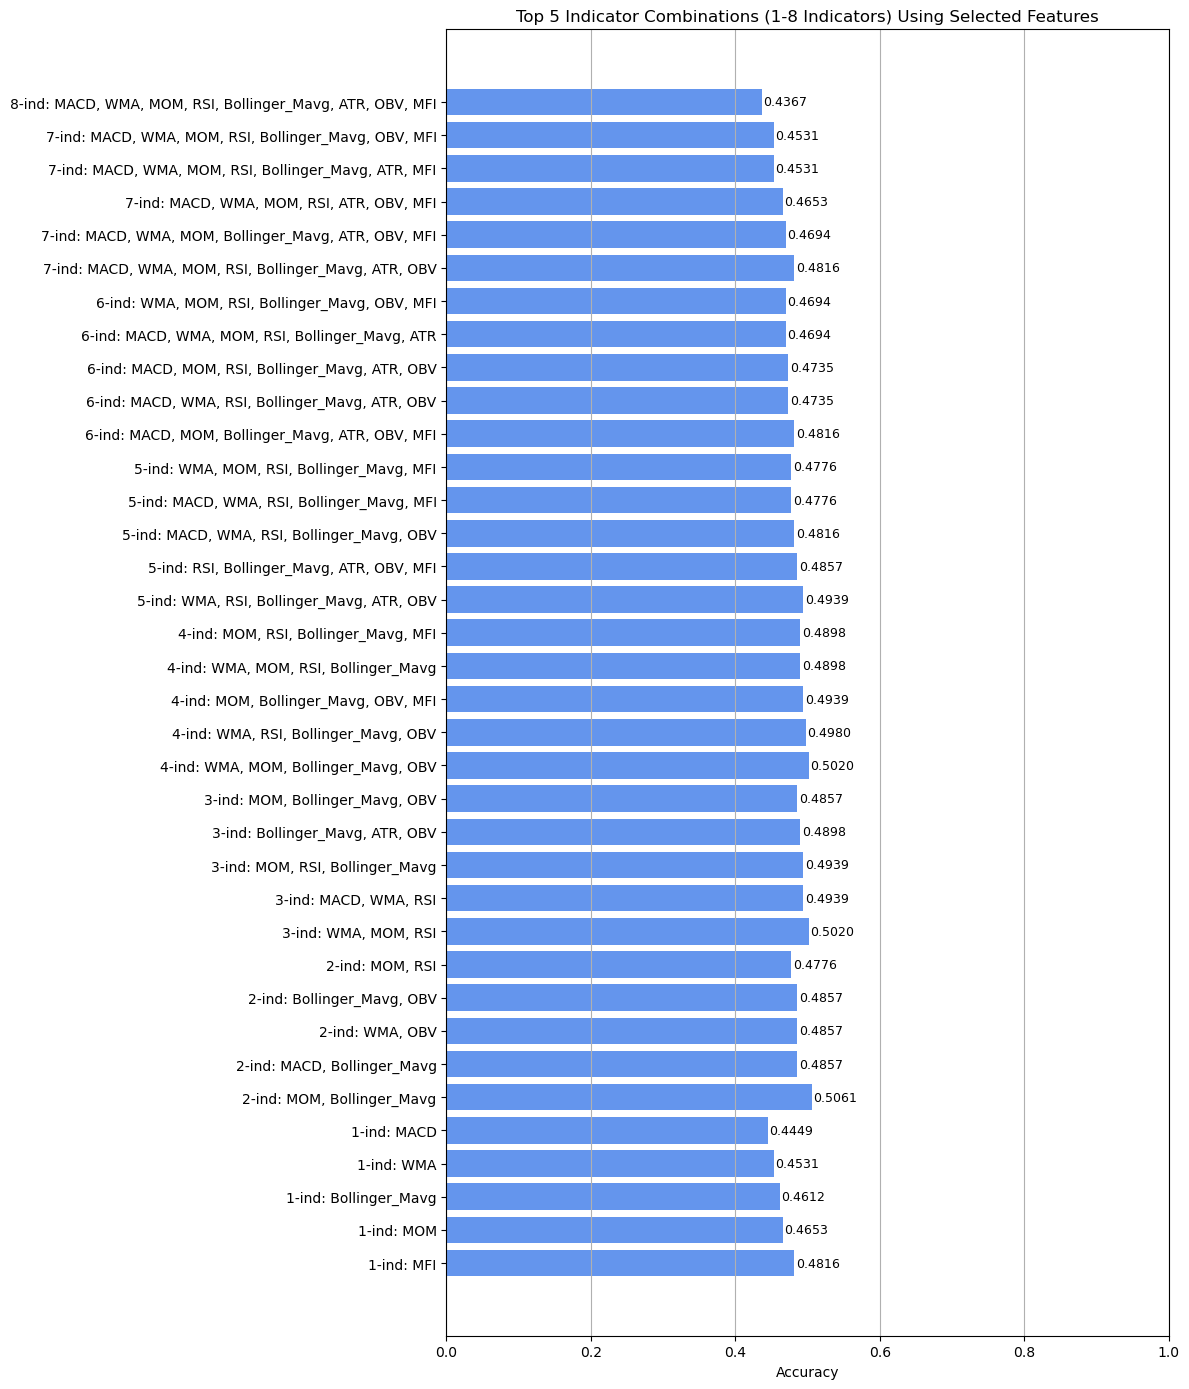

In [6]:
# =============================================================================
# PART 4: Evaluate Combinations of Selected Features (1-8 Indicators)
# =============================================================================
# Use the selected features dictionary to generate combinations from 1 to 8 indicators.
selected_features = {}
for category, imp_dict in feature_importances.items():
    # Sort features by importance and select top 2
    top_features = sorted(imp_dict, key=imp_dict.get, reverse=True)[:2] 
    selected_features[category] = top_features
# Flatten the dictionary into a list of 8 indicators
selected_indicators = [feat for feats in selected_features.values() for feat in feats]
print("\nSelected indicators for combination evaluation:", selected_indicators)

# Evaluate each combination size (from 1 to 8) using default AdaBoost
best_combinations = {}
for num in range(1, len(selected_indicators) + 1):
    comb_results = []
    for combo in itertools.combinations(selected_indicators, num):
        X_combo = data[list(combo)]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_combo)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, data['Target'], test_size=0.2, random_state=42, shuffle=False
        )
        model = AdaBoostClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        comb_results.append((combo, acc))
    # For each combination size, store the top 5 performing combinations
    top_5 = sorted(comb_results, key=lambda x: x[1], reverse=True)[:5]
    best_combinations[num] = top_5

# Prepare data for visualization of the best combinations (default parameters)
labels, accuracies = [], []
for num, combos in best_combinations.items():
    for combo, acc in combos:
        labels.append(f"{num}-ind: {', '.join(combo)}")
        accuracies.append(acc)

plt.figure(figsize=(12, 14))
plt.barh(labels, accuracies, color='cornflowerblue')
for bar in plt.gca().patches:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center', fontsize=9)
plt.xlabel('Accuracy')
plt.title('Top 5 Indicator Combinations (1-8 Indicators) Using Selected Features')
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


##5: Evaluate Combinations with Hyperparameter Optimization
Explanation
Optimize the AdaBoost classifier’s hyperparameters using GridSearchCV. We define a parameter grid (searching over various values of n_estimators and learning_rate), and then for each combination of selected indicators we search for the best hyperparameters. We record and visualize the top 5 optimized combinations for each combination size.

c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD',), Accuracy: 0.5196, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:00:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD',), Accuracy: 0.5098, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:00:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD',), Accuracy: 0.5490, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:01:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD',), Accuracy: 0.5392, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:01:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD',), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:01:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA',), Accuracy: 0.5343, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:01:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA',), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:01:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA',), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:01:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA',), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:01:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA',), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:01:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM',), Accuracy: 0.4216, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:01:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM',), Accuracy: 0.6078, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:01:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM',), Accuracy: 0.5539, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:02:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM',), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:02:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM',), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:02:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI',), Accuracy: 0.4951, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:02:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI',), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:02:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI',), Accuracy: 0.5735, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:02:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI',), Accuracy: 0.5245, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:02:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI',), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:02:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg',), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:02:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg',), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:02:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg',), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:03:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg',), Accuracy: 0.4657, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:03:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg',), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:03:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR',), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:03:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR',), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:03:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR',), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:03:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR',), Accuracy: 0.5392, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:03:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR',), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:03:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV',), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:03:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV',), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:03:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV',), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:04:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV',), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:04:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV',), Accuracy: 0.4412, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:04:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MFI',), Accuracy: 0.4118, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:04:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MFI',), Accuracy: 0.5882, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:04:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MFI',), Accuracy: 0.5735, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:04:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MFI',), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:04:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MFI',), Accuracy: 0.4314, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:04:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:04:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:04:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:05:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA'), Accuracy: 0.4706, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:05:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:05:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM'), Accuracy: 0.5196, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:05:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM'), Accuracy: 0.5882, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:05:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:05:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:05:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:05:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 10:05:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:05:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:06:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:06:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:06:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg'), Accuracy: 0.5196, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:06:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:06:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:06:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:06:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:06:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:06:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:07:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR'), Accuracy: 0.5294, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:07:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:07:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:07:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:07:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:07:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:07:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV'), Accuracy: 0.4804, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:07:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:07:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:08:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:08:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:08:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:08:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:08:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM'), Accuracy: 0.5196, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:08:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:08:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:08:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM'), Accuracy: 0.4706, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:08:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:08:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI'), Accuracy: 0.5245, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:09:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:09:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:09:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI'), Accuracy: 0.4657, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:09:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:09:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:09:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:09:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:09:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:09:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:09:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:09:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:10:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:10:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:10:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:10:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:10:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV'), Accuracy: 0.4265, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:10:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:10:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:10:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:10:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:10:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:10:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:11:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:11:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:11:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:11:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:11:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:11:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI'), Accuracy: 0.5245, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:11:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:11:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:11:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg'), Accuracy: 0.4510, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:11:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:11:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:12:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:12:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR'), Accuracy: 0.4559, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:12:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR'), Accuracy: 0.5294, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:12:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:12:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:12:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:12:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV'), Accuracy: 0.4951, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:12:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 10:12:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:13:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:13:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:13:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'MFI'), Accuracy: 0.4118, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:13:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'MFI'), Accuracy: 0.5735, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:13:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'MFI'), Accuracy: 0.5784, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:13:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'MFI'), Accuracy: 0.5441, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:13:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:13:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:13:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:14:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:14:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:14:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:14:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR'), Accuracy: 0.5000, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:14:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:14:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:14:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:14:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:14:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:15:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:15:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:15:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:15:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:15:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 10:15:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:15:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:15:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:16:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:16:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:16:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:16:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:16:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:16:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:16:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:16:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:16:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:16:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:17:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:17:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:17:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:18:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:18:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:18:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:19:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:19:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:19:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:19:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:19:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:19:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:20:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'MFI'), Accuracy: 0.5294, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:20:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'MFI'), Accuracy: 0.5686, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:20:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'MFI'), Accuracy: 0.5441, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:21:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:21:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV', 'MFI'), Accuracy: 0.4167, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:21:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:21:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:22:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:22:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:22:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM'), Accuracy: 0.4951, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:23:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:23:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:23:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:24:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:24:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI'), Accuracy: 0.5049, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:24:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI'), Accuracy: 0.4412, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:24:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI'), Accuracy: 0.4902, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:24:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI'), Accuracy: 0.4706, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:25:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:25:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:25:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:26:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:26:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:26:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:26:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:27:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR'), Accuracy: 0.4314, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:27:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:27:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:27:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:27:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:28:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:28:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:28:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:28:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:29:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:29:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:29:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:29:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 10:30:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:30:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:31:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:31:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:31:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:31:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:32:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.5098, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:32:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:32:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:33:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:33:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:33:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:33:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR'), Accuracy: 0.5784, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:33:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:33:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR'), Accuracy: 0.5392, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:33:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:33:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:34:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:34:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:34:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:34:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:34:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'MFI'), Accuracy: 0.5000, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:34:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'MFI'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:34:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:34:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:34:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:34:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:34:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:35:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:35:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:35:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:35:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR'), Accuracy: 0.4902, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:35:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:35:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:35:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:35:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:35:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:35:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:36:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:36:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:36:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:36:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:36:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'MFI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:36:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:36:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:36:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:36:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5196, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:36:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:36:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:37:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:37:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:37:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:37:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4314, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:37:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:37:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:37:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:37:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:37:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:37:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:38:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:38:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:38:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:38:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:38:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:38:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV'), Accuracy: 0.4804, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:38:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:38:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'MFI'), Accuracy: 0.4118, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:38:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:38:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:39:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:39:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:39:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:39:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:39:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:39:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:39:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:39:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI'), Accuracy: 0.5049, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:39:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:40:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:40:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:40:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:40:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.5245, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:40:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:41:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:41:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:41:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:41:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:42:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR'), Accuracy: 0.4265, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:42:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:42:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:42:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:42:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:43:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV'), Accuracy: 0.4167, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:43:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:43:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:43:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:44:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:44:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:44:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:44:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:44:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:44:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.5000, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:44:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:44:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:45:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:45:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:45:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR'), Accuracy: 0.5147, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:45:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR'), Accuracy: 0.4167, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:45:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:45:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:45:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:46:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV'), Accuracy: 0.5441, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:46:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:47:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:47:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:47:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:47:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:47:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:47:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:47:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:47:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:47:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:47:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:48:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:48:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:48:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:48:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:48:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:48:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:48:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:48:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:48:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:48:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:49:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:49:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:49:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:49:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:49:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:49:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:49:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:49:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:49:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:49:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:49:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:50:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:50:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:50:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:50:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:50:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:50:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:50:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:50:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.5000, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:50:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:50:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:50:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.5245, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:51:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:51:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:51:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:51:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:51:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:51:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:51:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV'), Accuracy: 0.4951, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:51:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:51:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 10:51:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:52:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:52:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:52:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:52:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:52:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'MFI'), Accuracy: 0.5245, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:52:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:52:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:52:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:52:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:52:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:52:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:52:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:53:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:53:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:53:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:53:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:53:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:53:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:53:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:53:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:53:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:53:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:53:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 10:53:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:54:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:54:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV'), Accuracy: 0.4265, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:54:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:54:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'MFI'), Accuracy: 0.5294, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:54:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'MFI'), Accuracy: 0.5686, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:54:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'MFI'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:54:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:54:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV', 'MFI'), Accuracy: 0.4069, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:54:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:54:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:54:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:54:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:55:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:55:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:55:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:55:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5245, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:55:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:55:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5000, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:55:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:55:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:55:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:55:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:55:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:55:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:55:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:56:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:56:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:56:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:56:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:56:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:56:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:56:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:56:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'MFI'), Accuracy: 0.5294, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:56:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:56:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:56:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:56:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:57:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 10:57:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:57:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:57:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:57:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:57:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:57:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:57:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:57:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:57:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:57:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:57:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:58:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:58:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:58:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 10:58:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:58:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 10:58:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 10:58:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:58:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 10:58:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:58:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 10:58:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 10:58:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 10:58:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('ATR', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 10:59:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:59:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:59:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI'), Accuracy: 0.5000, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 10:59:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:59:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 10:59:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.5000, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:59:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:59:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 10:59:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 10:59:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 10:59:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:00:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:00:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:00:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:00:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:00:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:00:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:00:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:00:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:00:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:00:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:00:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:00:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:01:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:01:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:01:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.5245, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:01:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:01:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:01:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4608, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:01:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:01:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR'), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:01:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR'), Accuracy: 0.4216, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:01:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR'), Accuracy: 0.4902, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:01:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:01:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:02:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:02:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:02:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:02:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:02:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:02:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:02:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:02:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:02:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:02:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:02:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:03:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:03:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:03:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:03:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:03:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4951, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:03:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:03:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:03:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:03:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:03:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:03:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:03:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:04:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:04:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:04:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:04:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV'), Accuracy: 0.4167, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:04:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:04:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:04:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:04:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:04:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:04:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:04:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:04:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:05:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:05:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV', 'MFI'), Accuracy: 0.4216, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:05:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:05:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:05:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:05:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4804, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:05:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:05:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:05:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:05:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:05:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:05:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:06:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:06:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:06:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:06:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:06:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:06:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:06:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:06:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:06:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:06:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'MFI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:06:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:06:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:07:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:07:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4951, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:07:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:07:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:07:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:07:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:07:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:07:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:07:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:07:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:07:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:08:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:08:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:08:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:08:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:08:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:08:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:08:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:08:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:08:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:08:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:08:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'MFI'), Accuracy: 0.5196, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:08:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:09:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:09:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:09:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:09:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:09:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:09:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:09:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:09:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:09:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4804, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:09:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:09:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:09:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:10:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:10:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5441, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:10:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:10:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:10:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:10:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:10:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:10:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:10:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:10:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:10:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:10:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:11:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:11:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:11:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:11:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:11:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:11:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:11:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:11:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:11:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:11:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:11:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:11:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:12:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:12:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:12:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:12:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4265, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:12:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:12:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:12:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:12:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:12:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:12:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:12:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:12:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:13:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:13:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:13:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:13:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:13:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:13:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:13:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:13:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:13:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:13:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:13:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:13:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:14:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:14:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:14:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:14:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4951, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:14:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4265, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:14:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:14:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:14:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:14:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.5196, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:14:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4265, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:14:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:14:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:15:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:15:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.5294, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:15:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:15:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:15:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:15:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:15:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:15:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:15:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:15:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:15:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:15:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:16:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:16:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:16:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:16:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:16:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:16:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:16:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:16:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:16:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:16:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4951, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:16:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:16:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:17:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:17:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4314, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:17:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:17:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:17:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:17:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:17:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:17:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:17:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4216, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:17:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:17:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:17:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:18:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4951, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:18:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4314, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:18:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:18:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:18:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:18:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5196, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:18:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:18:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:18:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:18:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:18:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:18:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:19:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:19:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:19:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:19:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:19:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4314, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:19:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:19:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:19:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:19:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5000, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:19:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:19:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:19:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:20:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:20:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:20:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:20:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:20:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:20:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:20:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:20:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:20:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:20:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:20:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:20:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:21:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:21:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:21:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:21:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:21:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:21:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:21:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:21:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:21:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:21:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:21:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:21:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:22:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:22:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:22:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:22:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:22:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:22:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:22:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:22:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:22:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:22:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:22:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:23:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:23:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:23:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:23:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:23:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:23:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:23:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:23:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:23:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:23:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:23:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:23:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:24:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:24:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5392, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:24:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:24:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:24:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:24:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:24:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:24:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:24:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:24:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:24:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:24:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:25:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:25:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:25:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:25:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:25:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:25:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:25:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:25:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:25:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:25:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:25:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:25:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:26:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:26:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:26:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:26:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:26:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:26:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:26:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:26:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:26:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:26:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:26:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:26:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:27:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:27:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:27:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:27:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5294, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:27:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:27:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:27:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:27:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:27:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5196, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:27:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:27:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:27:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:28:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:28:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:28:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:28:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:28:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:28:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:28:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.5196, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:28:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:28:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:28:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:28:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:29:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:29:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:29:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.5000, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:29:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:29:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:29:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.5000, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:29:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:29:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:29:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:29:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:29:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:29:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:30:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:30:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:30:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:30:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:30:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4265, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:30:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:30:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:30:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:30:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4951, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:30:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:30:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:31:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:31:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:31:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:31:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:31:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:31:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:31:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:31:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:31:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:31:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:31:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:31:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:32:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:32:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:32:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:32:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:32:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:32:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.5000, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:32:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:32:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:32:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:32:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:32:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:33:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:33:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:33:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:33:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:33:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5049, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:33:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:33:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:33:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:33:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:33:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.5245, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:33:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:33:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:34:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:34:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:34:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:34:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4265, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:34:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:34:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:34:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:34:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:34:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:34:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:34:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:35:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:35:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:35:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:35:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:35:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:35:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:35:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:35:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:35:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:35:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:36:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:36:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:36:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:36:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:36:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:36:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:36:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5392, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:36:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:36:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:36:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:37:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:37:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:37:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:37:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:37:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:37:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:37:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:37:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:37:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:38:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:38:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:38:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:38:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:38:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:38:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:38:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:38:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:38:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:38:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:39:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:39:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:39:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:39:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:39:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:39:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:39:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:39:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:39:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:39:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:39:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:40:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:40:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5000, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:40:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:40:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:40:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:40:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:40:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:40:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4902, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:40:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:40:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:41:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:41:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:41:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:41:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:41:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:41:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:41:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:41:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:41:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:41:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:42:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:42:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:42:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:42:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:42:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:42:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:42:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:42:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:42:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:42:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:43:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:43:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:43:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:43:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:43:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:43:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:43:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5441, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:43:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:43:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:43:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:44:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:44:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:44:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:44:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:44:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:44:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:44:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:44:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:44:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:44:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:45:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:45:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:45:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:45:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:45:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:45:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:45:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5196, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:45:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4216, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:45:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:45:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:46:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:46:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:46:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:46:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:46:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:46:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:46:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.5147, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:46:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:46:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:46:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:47:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4265, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:47:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:47:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:47:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:47:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:47:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4314, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:47:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.5, 'n_estimators': 100}, Time: 2025-03-10 11:47:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:47:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:47:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:48:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:48:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:48:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:48:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:48:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:48:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:48:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:48:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:48:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:48:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:48:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:49:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:49:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:49:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:49:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:49:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:49:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:49:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:49:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:49:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:49:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4265, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:50:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:50:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:50:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:50:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:50:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:50:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:50:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:50:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:50:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:50:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:51:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:51:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:51:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:51:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:51:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:51:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:51:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:51:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:51:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:51:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:51:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4951, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:52:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:52:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:52:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:52:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:52:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:52:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:52:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:52:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:52:53


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:52:58


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:53:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:53:08


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:53:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:53:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:53:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5000, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:53:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:53:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 11:53:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:53:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:53:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:53:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5588, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:54:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5490, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:54:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:54:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:54:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:54:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:54:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:54:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:54:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:54:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:54:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:54:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:55:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:55:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:55:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:55:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:55:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:55:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:55:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:55:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.5147, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 11:55:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:55:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:55:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:56:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:56:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 11:56:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:56:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:56:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:56:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:56:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4510, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 11:56:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:56:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:56:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:56:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:57:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:57:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:57:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:57:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 11:57:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:57:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.5245, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:57:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:57:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:57:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:57:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 11:57:57


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4657, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 11:58:02


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4265, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:58:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:58:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:58:18


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:58:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:58:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:58:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:58:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:58:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 11:58:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:58:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:59:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 11:59:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 11:59:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:59:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:59:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:59:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 11:59:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 11:59:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 11:59:46


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 50}, Time: 2025-03-10 11:59:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4314, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 11:59:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:00:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 12:00:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:00:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 50}, Time: 2025-03-10 12:00:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:00:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:00:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:00:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:00:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:00:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:00:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:00:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:01:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:01:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:01:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 12:01:16


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:01:22


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 1.0, 'n_estimators': 100}, Time: 2025-03-10 12:01:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:01:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:01:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:01:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:01:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 12:01:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:02:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.5392, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:02:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:02:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 12:02:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 12:02:21


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:02:27


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 12:02:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:02:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:02:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:02:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:02:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 1.0, 'n_estimators': 200}, Time: 2025-03-10 12:03:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:03:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:03:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:03:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:03:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 200}, Time: 2025-03-10 12:03:28


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5637, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:03:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5147, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:03:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:03:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:03:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:03:55


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:04:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:04:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:04:11


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:04:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5294, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:04:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:04:33


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:04:41


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:04:47


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:04:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:04:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:05:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 12:05:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:05:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:05:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4902, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 12:05:31


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:05:36


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 12:05:42


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:05:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 12:05:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 1.0, 'n_estimators': 300}, Time: 2025-03-10 12:06:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:06:06


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 12:06:12


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:06:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:06:26


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 12:06:32


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:06:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:06:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 12:06:52


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:07:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:07:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:07:17


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 12:07:23


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:07:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:07:37


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:07:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:07:48


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:07:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:07:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:08:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 12:08:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:08:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:08:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:08:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:08:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.5196, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:08:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:08:38


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:08:43


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 100}, Time: 2025-03-10 12:08:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:08:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.5098, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 12:08:59


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:09:03


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:09:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:09:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'MFI'), Accuracy: 0.4657, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:09:20


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.5343, Params: {'learning_rate': 0.1, 'n_estimators': 300}, Time: 2025-03-10 12:09:24


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:09:29


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 12:09:34


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 12:09:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:09:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.5, 'n_estimators': 300}, Time: 2025-03-10 12:09:50


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:09:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:10:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:10:05


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4559, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 12:10:10


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:10:15


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:10:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:10:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:10:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:10:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5049, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:10:39


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4510, Params: {'learning_rate': 0.1, 'n_estimators': 100}, Time: 2025-03-10 12:10:44


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:10:49


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:10:54


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:11:00


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.5, 'n_estimators': 200}, Time: 2025-03-10 12:11:04


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4363, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:11:09


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4461, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:11:14


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4853, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:11:19


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:11:25


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4804, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:11:30


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:11:35


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 200}, Time: 2025-03-10 12:11:40


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4706, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:11:45


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:11:51


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.5245, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:11:56


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4608, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:12:01


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.01, 'n_estimators': 300}, Time: 2025-03-10 12:12:07


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4755, Params: {'learning_rate': 0.1, 'n_estimators': 50}, Time: 2025-03-10 12:12:13


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Combination: ('MACD', 'WMA', 'MOM', 'RSI', 'Bollinger_Mavg', 'ATR', 'OBV', 'MFI'), Accuracy: 0.4412, Params: {'learning_rate': 0.01, 'n_estimators': 50}, Time: 2025-03-10 12:12:20


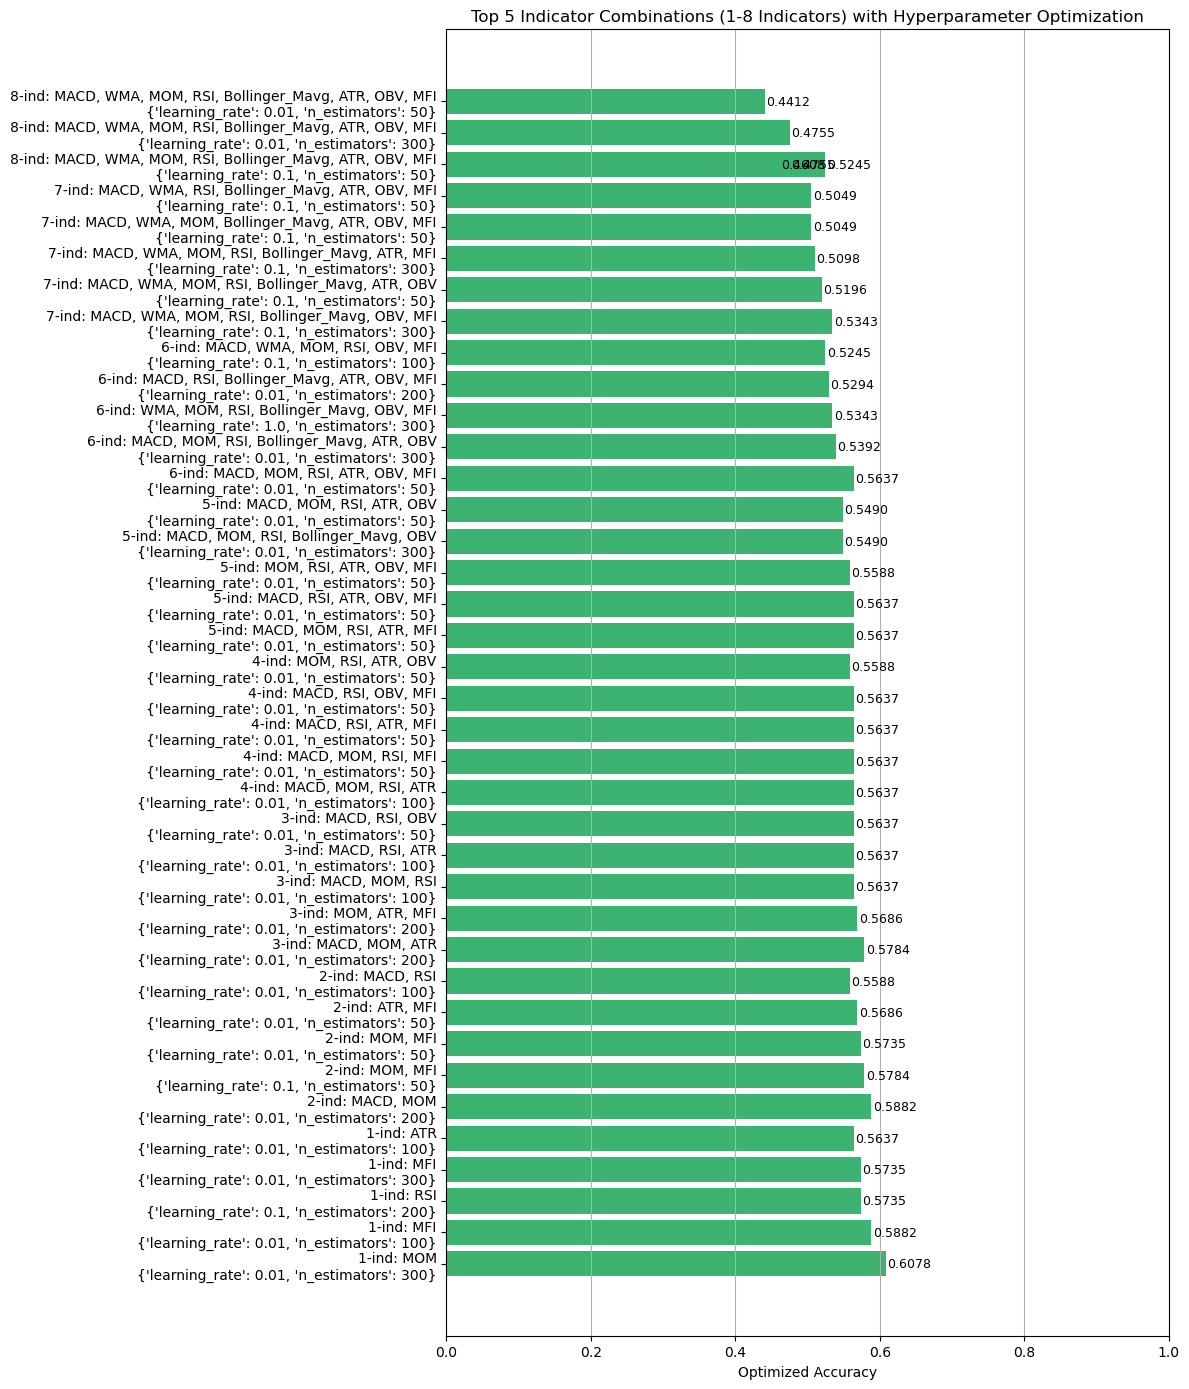

In [7]:
# =============================================================================
# PART 5: Evaluate Combinations with Hyperparameter Optimization
# =============================================================================
# Here we use GridSearchCV to optimize hyperparameters for each combination.
from sklearn.model_selection import TimeSeriesSplit  # Import TimeSeriesSplit
import time
# Expanded Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # More values for n_estimators
    'learning_rate': [0.01, 0.1, 0.5, 1.0]  # More values for learning_rate
}

best_combinations_opt = {}
for num in range(1, len(selected_indicators) + 1):
    comb_results = []
    for combo in itertools.combinations(selected_indicators, num):
        X_combo = data[list(combo)]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_combo)

        # Use TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=5)

        for train_index, test_index in tscv.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = data['Target'].iloc[train_index], data['Target'].iloc[test_index]

            ada = AdaBoostClassifier(random_state=42)
            grid_search = GridSearchCV(ada, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            acc = accuracy_score(y_test, best_model.predict(X_test))
            # Display accuracy and runtime
            print(f"Combination: {combo}, Accuracy: {acc:.4f}, Params: {grid_search.best_params_}, Time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
            comb_results.append((combo, acc, grid_search.best_params_))

    # Store top 5 optimized combinations
    top_5_opt = sorted(comb_results, key=lambda x: x[1], reverse=True)[:5]
    best_combinations_opt[num] = top_5_opt
# Prepare data for visualization of the optimized results
labels_opt, accuracies_opt = [], []
for num, combos in best_combinations_opt.items():
    for combo, acc, best_params in combos:
        labels_opt.append(f"{num}-ind: {', '.join(combo)}\n{best_params}")
        accuracies_opt.append(acc)

plt.figure(figsize=(12, 14))
plt.barh(labels_opt, accuracies_opt, color='mediumseagreen')
for bar in plt.gca().patches:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center', fontsize=9)
plt.xlabel('Optimized Accuracy')
plt.title('Top 5 Indicator Combinations (1-8 Indicators) with Hyperparameter Optimization')
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


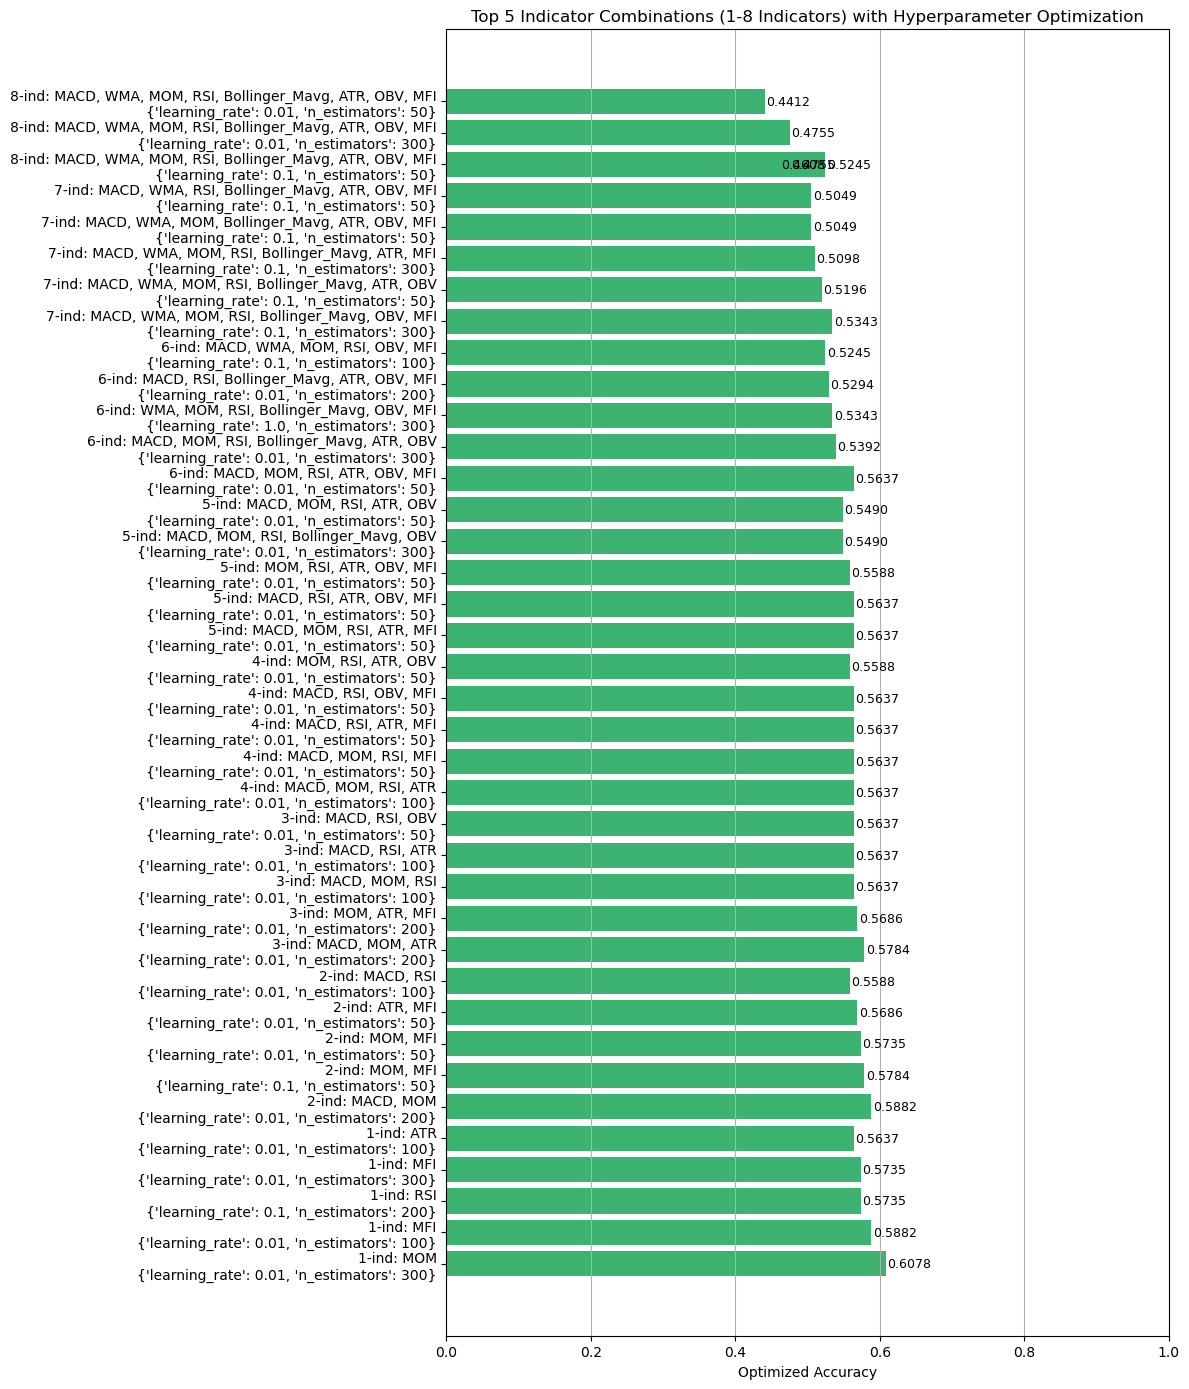

In [8]:
# Prepare data for visualization of the optimized results
labels_opt, accuracies_opt = [], []
for num, combos in best_combinations_opt.items():
    for combo, acc, best_params in combos:
        labels_opt.append(f"{num}-ind: {', '.join(combo)}\n{best_params}")
        accuracies_opt.append(acc)

plt.figure(figsize=(12, 14))
plt.barh(labels_opt, accuracies_opt, color='mediumseagreen')
for bar in plt.gca().patches:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center', fontsize=9)
plt.xlabel('Optimized Accuracy')
plt.title('Top 5 Indicator Combinations (1-8 Indicators) with Hyperparameter Optimization')
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()